# Entrenamiento de Modelos

Una vez tenemos todo el procesado de datos hecho, procedemos leer los datos procesados y aplicar distintos modelos de regresion para predecir el precio de nuestras instancias.

Para ello dado que el objetivo de nuestro problema no es clasificar nuestros datos en distintas clases si no que tenemos que predecir el valor de una de las variables, tenemos un problema de regresión.

Para resolver el problema aplicaremos distintos modelos de regresión:
- **Regresión Lineal** (sin regularizacion L1 (Lasso) ni L2(Ridge), ya que no esperamos tener buenos resultados ajustando una recta pese a usar regularización)
- **SVM Linear** 
- **Random Forest**
- **Gradient Bosting**
- **XGBoost**
- **StackingClassifier**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

### Lectura de los datos

In [2]:
df_train = pd.read_csv("../processed_train.csv", header= 0, delimiter = ',')
df_test = pd.read_csv("../processed_test.csv",  header= 0, delimiter = ',')
df_original = pd.read_csv("../test.csv",  header= 0, delimiter = ',')

In [3]:
df_original = df_original.dropna(subset=['Location.Address.CountyOrParish'])

### Escalado

Dado que como hemos observado al hacer el procesado de datos, nuestras variables toman valores con magnitudes muy distintas, procedemos a aplicar una transformación MinMax la cual ajusta cada valor de la variable para que esté dentro del rango deseado [0, 1], calculando su posición relativa entre el valor mínimo y máximo de la misma variable.
<center>$\frac{X - X_{min}}{X_{max} - X_{min}}$</center>

In [4]:
scaler = MinMaxScaler()

X_train = df_train.drop(columns=['close_price'])
y_train = df_train['close_price']

X_test = df_test.drop(columns=['close_price'])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### PCA

Dado que tenemos un dataset con 125000 instancias aproximadamente y 48 variables, nos gustaria aplicar algun metodo de **Reducción de Dimensionalidad** como PCA para mirar si podemos transformar nuestros datos a un espacio de dimensiones mas bajo sacrificando un poco de varianza explicada pero ganando en tiempo de computación.

Procedemos a aplicar PCA para todas las componentes y vemos si nos podemos quedar con un nombre reducido de variables

In [18]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.47823321e-01 1.25086020e-01 1.17291435e-01 9.30495718e-02
 8.51412475e-02 6.39872252e-02 5.56591374e-02 4.40297323e-02
 3.57972070e-02 2.18806912e-02 1.81834092e-02 1.51511030e-02
 1.25672161e-02 1.03728703e-02 1.00015880e-02 9.35311124e-03
 6.30245375e-03 4.32409391e-03 3.88912194e-03 3.44868599e-03
 2.47580478e-03 2.21474326e-03 1.86194679e-03 1.70582807e-03
 1.53484535e-03 1.20213957e-03 1.05899809e-03 8.67167162e-04
 7.57259179e-04 7.45928328e-04 6.61437716e-04 4.27097033e-04
 3.85722400e-04 2.61763067e-04 2.02932460e-04 1.49637720e-04
 8.81904184e-05 3.08050416e-05 2.85118972e-05 1.83954888e-17
 2.50298760e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.24782332 0.37290934 0.49020078 0.58325035 0.6683916  0.73237882
 0.78803796 0.83206769 0.8678649  0.88974559 0.907929   0.9230801
 0.93564732 0.94602019 0.95602177 0.96537489 0.97167734 0.97600143
 0.97989056 0.98333924 0.98581505 0.98802979 0.98989174 0.99159756
 0.99313241 0.99433455 0.99539355 0.99626071 

Procedemos ahora a mostrar el **Gráfico del Codo** para ver como evoluciona la varianxa individual explicada con la acomulada

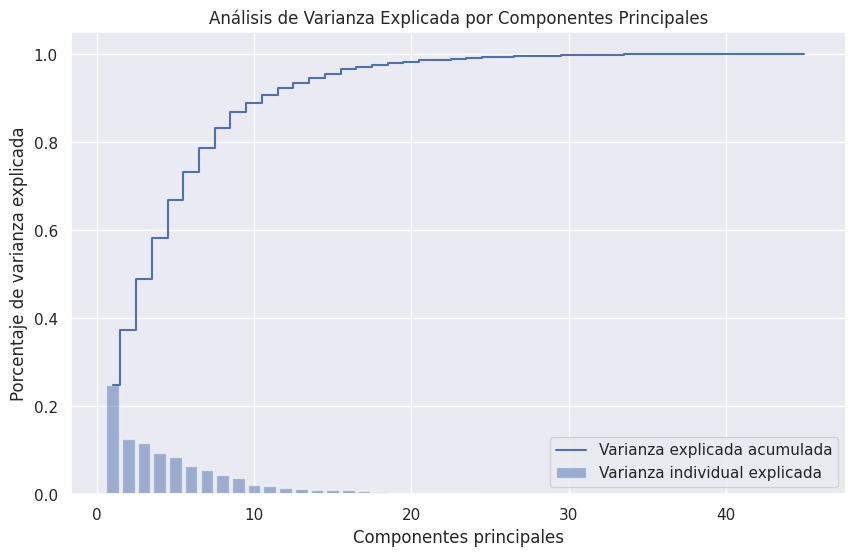

In [19]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza individual explicada')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza explicada')
plt.legend(loc='best')
plt.title('Análisis de Varianza Explicada por Componentes Principales')
plt.show();

Si observamos el gráfico del codo, vemos que si cojemos las 10 principales componentes, alcanzamos una varianza explicada de un 85% aproximadamente, asi que si en algun modelo vemos que el tiempo de computo es muy elevado, usaremos nuestros datos transformados a esas componentes para reducir su tiempo de ejecución.

A continuación mostramos el gŕafico de las **Cargas de Componentes Principales**, para las primeras 7 componentes dado que si no la visualización se nos haria muy complicada

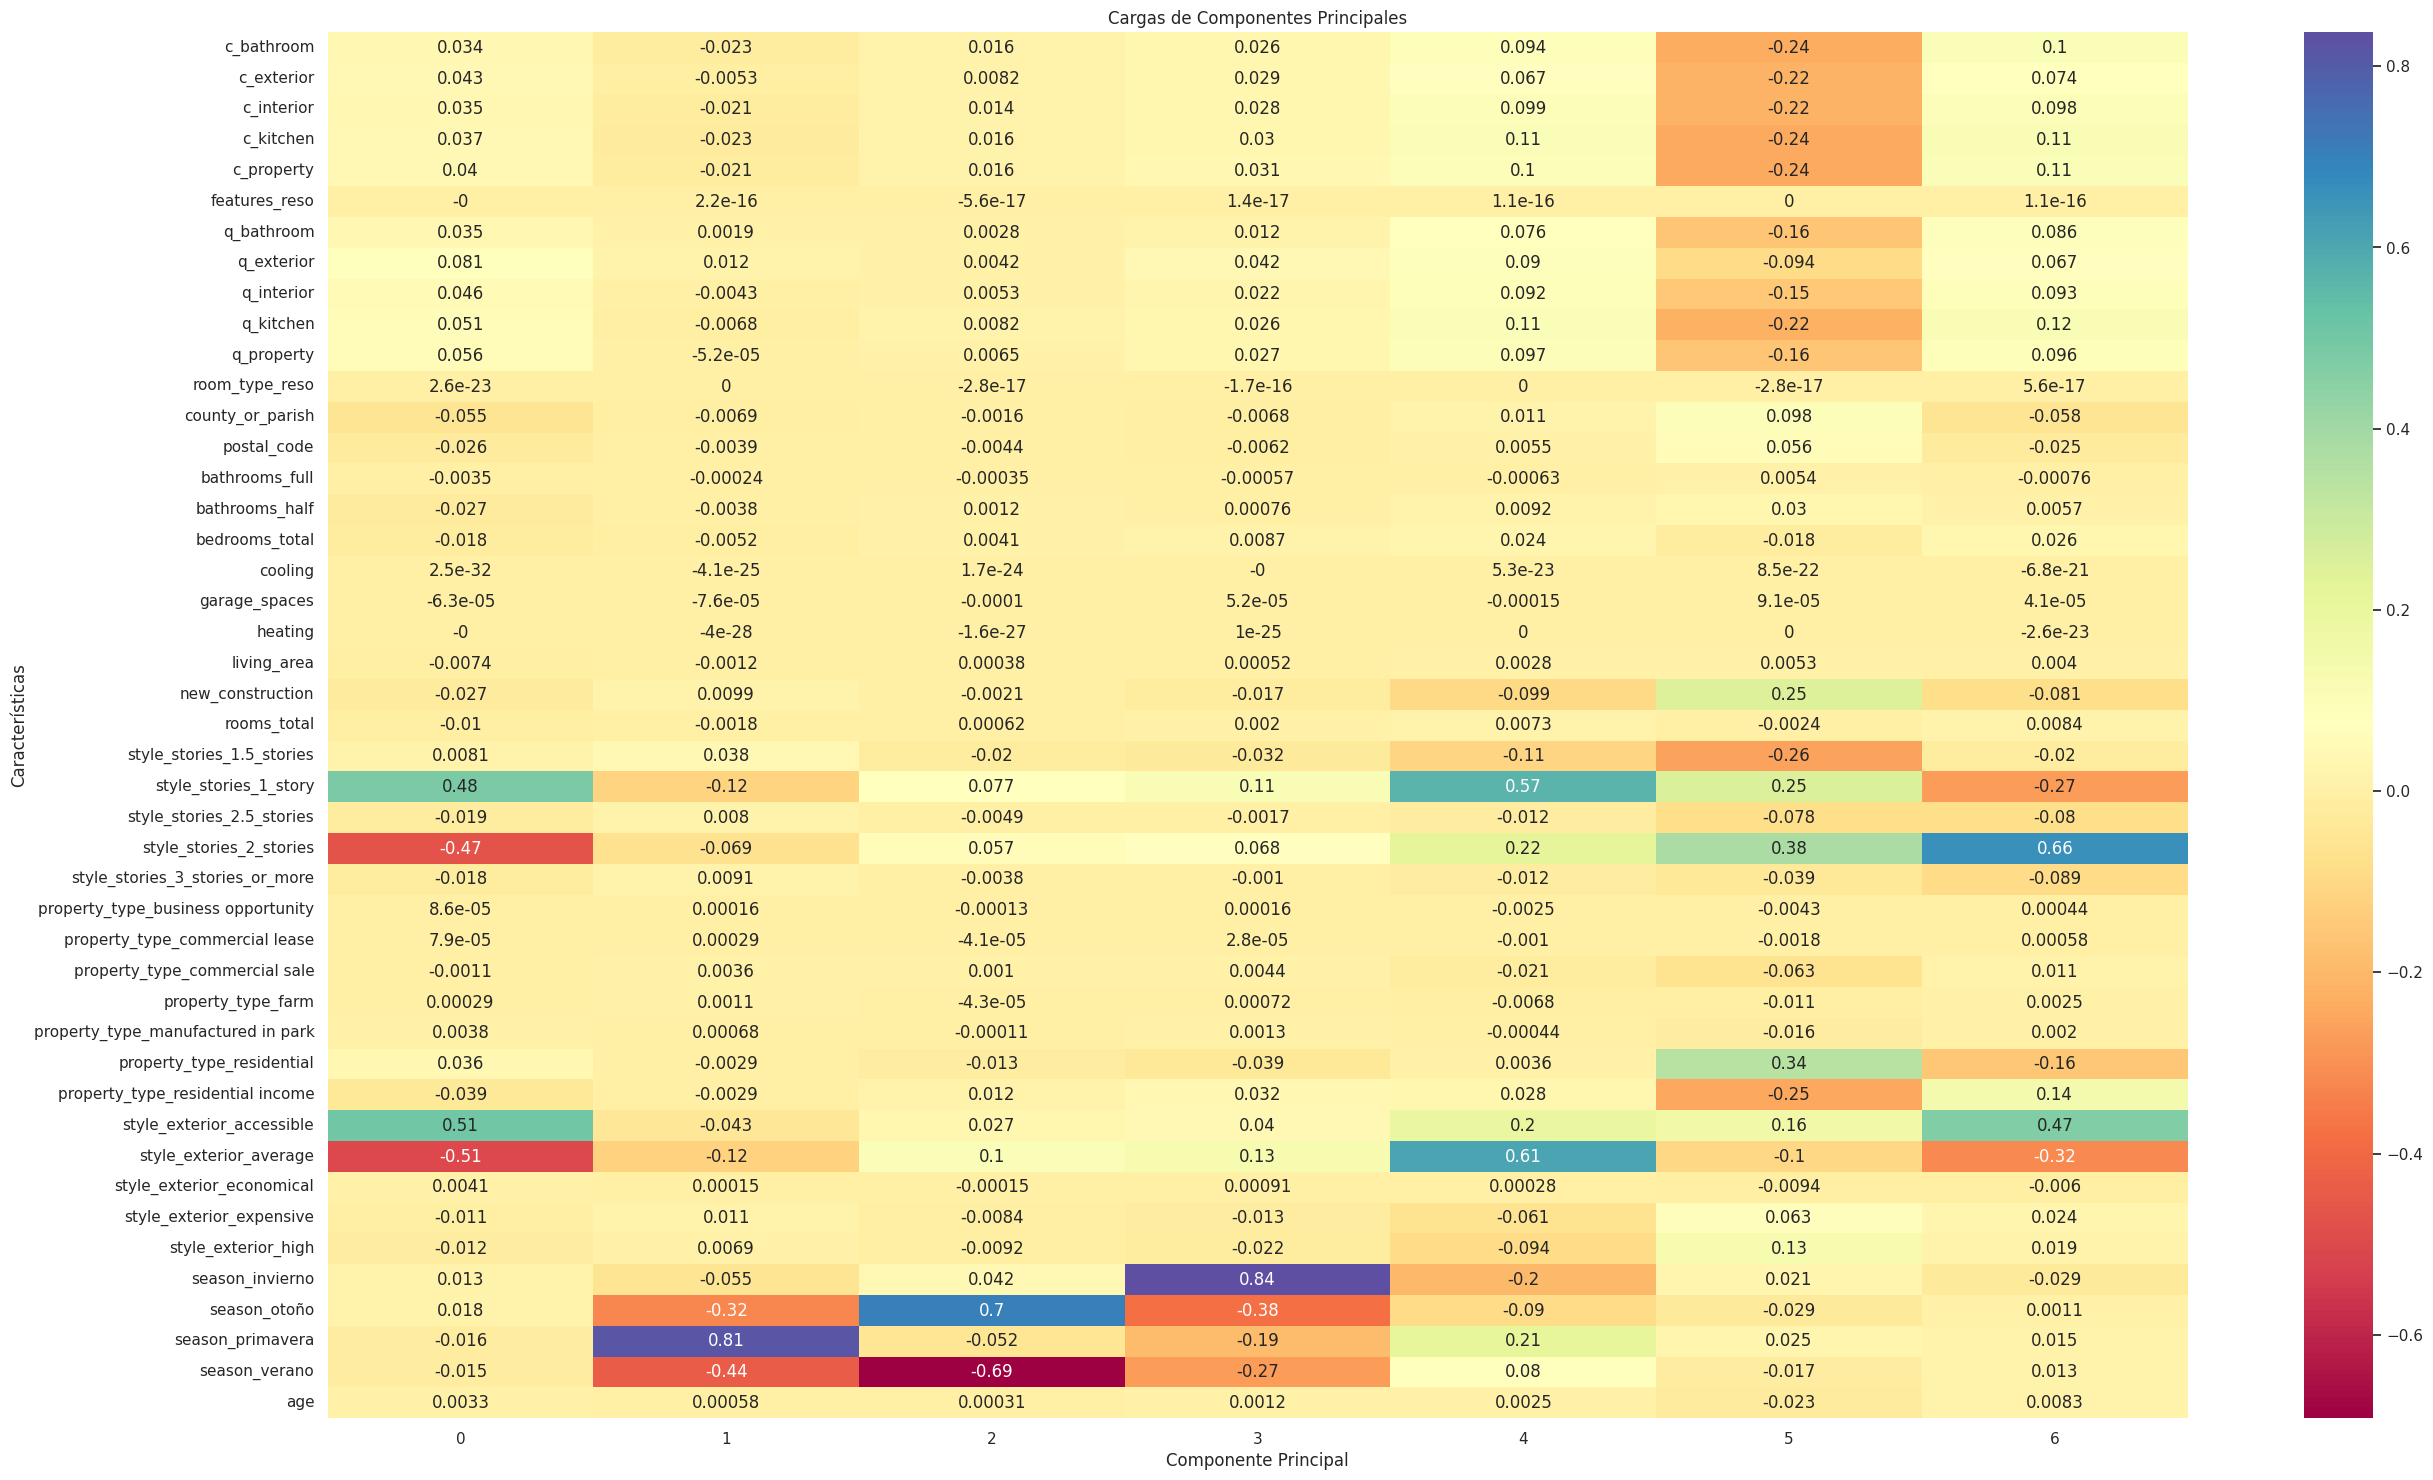

In [20]:
plt.figure(figsize=(30, 18))
components = pca.components_[:7]
sns.heatmap(components.T, cmap='Spectral', annot=True, yticklabels=X_train.columns)
plt.title('Cargas de Componentes Principales')
plt.xlabel('Componente Principal')
plt.ylabel('Características')
plt.show()

Vemos que importancia tiene cada variable en las distintas componentes, observamos que
- la primera le da mucho peso positivo la variable style_stories_1 y el style_exterior_accessible y por otra parte, style_stories_2 y style_exterior_average tienen la misma cantidad de peso pero negativo
- la segunda componente se centra mucho en la época del año, dando mucho peso positivo a la primavera y peso negativo al otoño y al verano
- la tercera y la cuarta vemos que tambien hacen referencia a la estacionalidad pero cada una le da mas peso a una estacion distinta
- la quinta componente se centra en variables como style_stories_1 y style_exterior_average

### T-SNE

A continuación aplicaremos tambien el método T-SNE (t-distributed Stochastic Neighbor Embedding) que es una técnica de reducción de dimensionalidad que se utiliza principalmente para la visualización de datos de alta dimensión. El algoritmo se basa en preservar la distancia entre pares de instancias trantando de reducir el espacio a 2 3 componentes lo que conlleva a que no suele ser muy útil para despues trabajar con los datos obtenidos ya que pasa de 49 variables a 3 y pierde mucha varianza explicada.

Se usa principalmente para reducir el espacio de variables a un espacio 2-dimensional o 3-dimensional para obtener una visualización gráfica de las instancias y ver si hay ciertos clusters o patrones en los datos. 

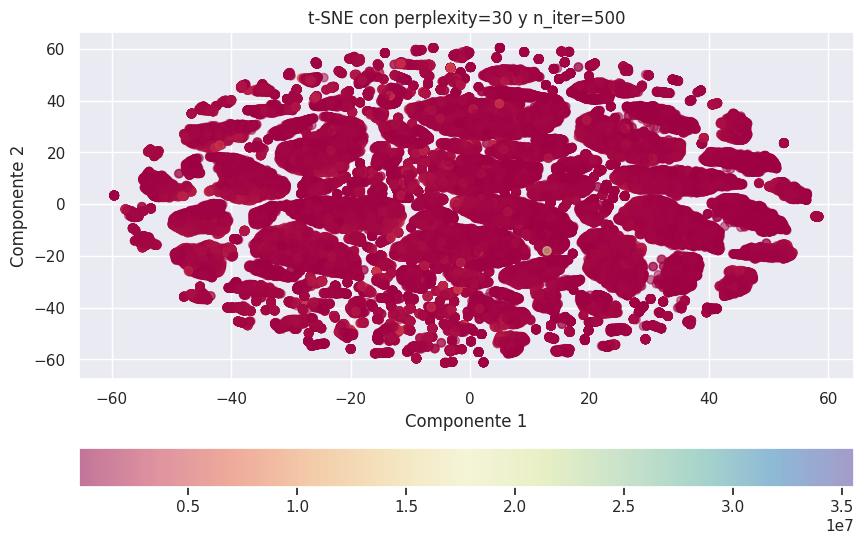

In [31]:
perplexity = 30
n_iter = 500

tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
data_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_train, cmap='Spectral', alpha=0.5)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title(f't-SNE con perplexity={perplexity} y n_iter={n_iter}')
plt.colorbar(scatter, orientation='horizontal', fraction=.1)
plt.show()


Tras aplicar T-SNE, observamos que si que hay ciertas agrupaciones de nuestros en los datos y por otra parte tenemos una nube de puntos que se ajusta muy bien a una elipse gaussiana cosa que siempre beneficia a la calidad de los datos y por lo tanto repercute positivamente en el futuro resultado de los modelos.

### Regresion lineal

Empezaremos aplicando el modelo mas simple, una regresión lineal. Del que no esperamos obtener muy buenos resultados dado que tratamos con variables que son independientes entre si, pero siempre esta bien tener una representación cuantificada de un modelo simple para comparar posteriormente.

In [22]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [23]:
train_predictions = model.predict(X_train_scaled)

mse = mean_squared_error(y_train, train_predictions)
print(f"Mean Squared Error (MSE): {mse}")

mae = mean_absolute_error(y_train, train_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = model.score(X_train_scaled, y_train)
print(f"R^2: {r2}")

#test_predictions = model.predict(X_test_scaled)

Mean Squared Error (MSE): 83691295157.84373
Mean Absolute Error (MAE): 135235.61148112785
R^2: 0.44003943770455556


#### Funcion para guardar los resultados

In [7]:
def store_results(model_name, model, y_train, train_predictions, X_test_scaled, df_original):
    results_dict = {
        'Model': [],
        'MSE': [],
        'MAE': [],
        'R2': []
    }

    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    r2 = r2_score(y_train, train_predictions)

    results_dict['Model'].append(model_name)
    results_dict['MSE'].append(mse)
    results_dict['MAE'].append(mae)
    results_dict['R2'].append(r2)

    results_df = pd.DataFrame(results_dict)
    results_df.to_csv(f'{model_name}_results.csv', index=False)

    test_predictions = model.predict(X_test_scaled)

    results = pd.DataFrame({
        'listing_id': df_original['Listing.ListingId'],
        'close_price': test_predictions
    })

    results.to_csv(f'{model_name}_predictions.csv', index=False)

    return results_dict, results


In [38]:
results_dict, results = store_results('LinearRegression', model, y_train, train_predictions, X_test_scaled, df_original)

### SVM Linear

In [24]:
from sklearn.svm import SVR

svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)

train_predictions_svr = svr_model.predict(X_train_scaled)

mse_train_svr = mean_squared_error(y_train, train_predictions_svr)
mae_train_svr = mean_absolute_error(y_train, train_predictions_svr)
r2_train_svr = r2_score(y_train, train_predictions_svr)

print(f"SVR Lineal - Training MSE: {mse_train_svr}")
print(f"SVR Lineal - Training MAE: {mae_train_svr}")
print(f"SVR Lineal - Training R^2: {r2_train_svr}")

SVR Lineal - Training MSE: 152786350430.29
SVR Lineal - Training MAE: 189595.3657009886
SVR Lineal - Training R^2: -0.022260804264727208


In [40]:
results_dict_svr, results_svr = store_results('SVR', svr_model, y_train, train_predictions_svr, X_test_scaled, df_original)

## Random Forest

In [89]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

rf_model.fit(X_train_scaled, y_train)

train_predictions_rf = rf_model.predict(X_train_scaled)

mse_train_rf = mean_squared_error(y_train, train_predictions_rf)
mae_train_rf = mean_absolute_error(y_train, train_predictions_rf)
r2_train_rf = r2_score(y_train, train_predictions_rf)

print(f"Random Forest - Training MSE: {mse_train_rf}")
print(f"Random Forest - Training MAE: {mae_train_rf}")
print(f"Random Forest - Training R^2: {r2_train_rf}")
print(f"Random Forest - Cross-Validation MSE: {-cv_scores.mean()}")
print(f"Random Forest - Cross-Validation Std: {cv_scores.std()}")


Random Forest - Training MSE: 11565843206.538315
Random Forest - Training MAE: 49353.65468531062
Random Forest - Training R^2: 0.9226154159385457
Random Forest - Cross-Validation MSE: 62980032947.914734
Random Forest - Cross-Validation Std: 21239708485.030968


In [90]:
results_dict_rf, results_rf = store_results('RandomForest', rf_model, y_train, train_predictions_rf, X_test_scaled, df_original)

## Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# Crear y entrenar el modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
train_predictions_gb = gb_model.predict(X_train_scaled)

# Evaluar en entrenamiento
mse_train_gb = mean_squared_error(y_train, train_predictions_gb)
mae_train_gb = mean_absolute_error(y_train, train_predictions_gb)
r2_train_gb = r2_score(y_train, train_predictions_gb)

print(f"Gradient Boosting - Training MSE: {mse_train_gb}")
print(f"Gradient Boosting - Training MAE: {mae_train_gb}")
print(f"Gradient Boosting - Training R^2: {r2_train_gb}")

Gradient Boosting - Training MSE: 56903182163.84643
Gradient Boosting - Training MAE: 97424.60426022355
Gradient Boosting - Training R^2: 0.6192729743186293


In [43]:
results_dict_gb, results_gb = store_results('GradientBoosting', gb_model, y_train, train_predictions_gb, X_test_scaled, df_original)

## XGBoost

In [10]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)

# parameters used for GridSearchCV
# param_grid = {
#     'n_estimators': [100, 300, 400, 500],
#     'learning_rate': [0.01, 0.1, 0.3, 0.5],
#     'max_depth': [4, 6, 8, 10]
# }

param_grid = {
    'n_estimators': [800],
    'learning_rate': [0.05],
    'max_depth': [10]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

best_xgb_model = xgb.XGBRegressor(**best_params, random_state=42)

best_xgb_model.fit(X_train_scaled, y_train)

train_predictions_xgb = best_xgb_model.predict(X_train_scaled)

mse_train_xgb = mean_squared_error(y_train, train_predictions_xgb)
mae_train_xgb = mean_absolute_error(y_train, train_predictions_xgb)
r2_train_xgb = r2_score(y_train, train_predictions_xgb)

print(f"XGBoost - Training MSE: {mse_train_xgb}")
print(f"XGBoost - Training MAE: {mae_train_xgb}")
print(f"XGBoost - Training R^2: {r2_train_xgb}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 800}
XGBoost - Training MSE: 3521046242.2552643
XGBoost - Training MAE: 34338.163316558996
XGBoost - Training R^2: 0.9764414324098707


In [8]:
# xgb_model = xgb.XGBRegressor(n_estimators=450, learning_rate=0.2, max_depth=7, random_state=42)

# xgb_model.fit(X_train_scaled, y_train)

# train_predictions_xgb = xgb_model.predict(X_train_scaled)

# mse_train_xgb = mean_squared_error(y_train, train_predictions_xgb)
# mae_train_xgb = mean_absolute_error(y_train, train_predictions_xgb)
# r2_train_xgb = r2_score(y_train, train_predictions_xgb)

# print(f"XGBoost - Training MSE: {mse_train_xgb}")
# print(f"XGBoost - Training MAE: {mae_train_xgb}")
# print(f"XGBoost - Training R^2: {r2_train_xgb}")

KeyboardInterrupt: 

In [11]:
results_dict_xgb, results_xgb = store_results('XGBoost', best_xgb_model, y_train, train_predictions_xgb, X_test_scaled, df_original)

In [12]:
median_close_price = results_xgb['close_price'].median()
print(f"La mediana de los valores 'close_price' de results_xgb es: {median_close_price}")

La mediana de los valores 'close_price' de results_xgb es: 333473.25


In [13]:
df_len_test = pd.read_csv("../test.csv", header=0, delimiter=',')

In [14]:

results_xgb.loc[results_xgb['close_price'] < 0, 'close_price'] = median_close_price

missing_ids = df_len_test[~df_len_test['Listing.ListingId'].isin(results_xgb['listing_id'])]['Listing.ListingId']

missing_data = pd.DataFrame({
    'listing_id': missing_ids,
    'close_price': median_close_price
})

results_xgb = pd.concat([results_xgb, missing_data], ignore_index=True)

In [15]:
results_xgb.to_csv('Definitivo_de_verdad.csv', index=False)